In [1]:
img_dim = 28 
import numpy as np                 # For Numerical Operations and Array Handling.
import matplotlib.pyplot as plt    # For Plotting Graphs and Visualizations.

from os.path import join           # For Joining File and Directory Paths.
from scipy.ndimage import rotate   # For Rotating Images or Arrays.

In [2]:
file_path = "/kaggle/input/mnist-dataset"
train_image_path = join(file_path, 'train-images.idx3-ubyte')
train_labels_path = join(file_path, 'train-labels.idx1-ubyte')
test_image_path = join(file_path, 't10k-images.idx3-ubyte')
test_labels_path = join(file_path, 't10k-labels.idx1-ubyte')

Labels Shape:  (60000,)
Images Shape:  (60000, 28, 28)


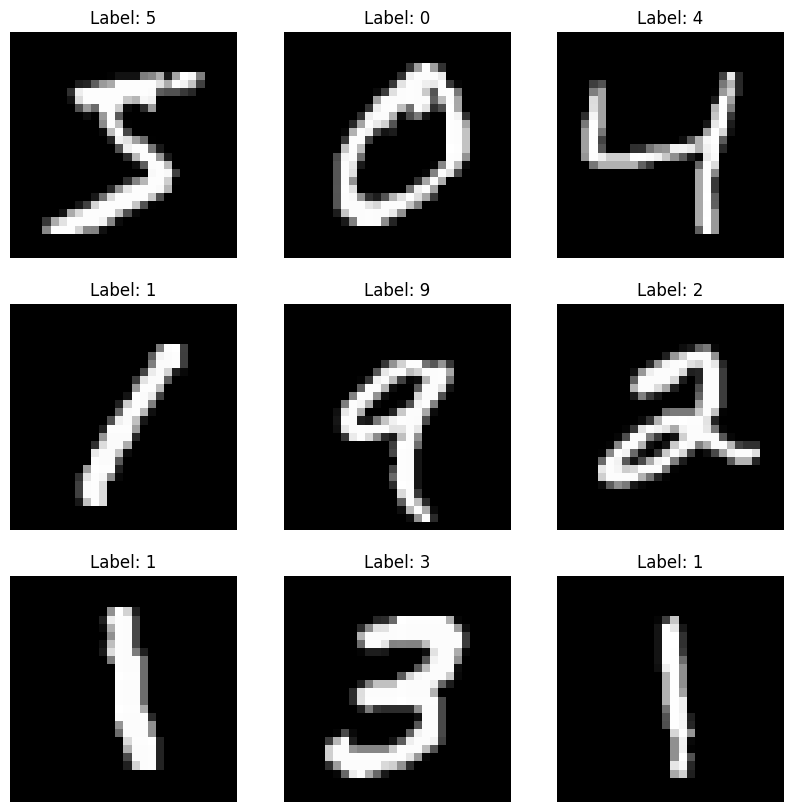

In [3]:
with open(train_image_path, "rb") as img_file:
    img_data = np.frombuffer(img_file.read(), dtype = np.uint8)

with open(train_labels_path, "rb") as lbl_file:
    label_file = np.frombuffer(lbl_file.read(), dtype = np.uint8)
    
labels = label_file[8:]
print("Labels Shape: ", labels.shape)

images = img_data[16:].reshape(-1, img_dim, img_dim)
print("Images Shape: ", images.shape)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap = "gray")
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

In [4]:
def randomRotation(images, max_angle = 15):
    # Function to Randomly Rotate Images
    rotated_images = []
    
    for image in images:
        decision = np.random.rand()                       # Random Probability
        
        # Apply Pre-Processing (or Rotate) with 50% Probability
        if decision < 0.5:
            rotated_images.append(image)
        else:
            angle = np.random.uniform(-max_angle, max_angle)
            rotated_image = rotate(image, angle, reshape = False, mode = "nearest")
            rotated_images.append(rotated_image)
            
    return np.array(rotated_images)

def horizontalFlip(images):
    # Function to Randomly Flip Images Horizontally
    flipped_images = []
    
    for image in images:
        decision = np.random.rand()

        # Apply Pre-Processing with 50% Probability
        if decision < 0.5:
            flipped_images.append(image)
        else:
            flipped_images.append(np.fliplr(image))
            
    return np.array(flipped_images)

class MNIST_DataLoader:
    def __init__(self, train_image_path, train_labels_path, test_image_path, test_labels_path, img_dim, preprocessors = None):
        self.train_image_path = train_image_path
        self.train_labels_path = train_labels_path
        self.test_image_path = test_image_path
        self.test_labels_path = test_labels_path
        self.img_dim = img_dim
        self.preprocessors = preprocessors if preprocessors is not None else []

    def readImageLabels(self, image_path, label_path):
        with open(image_path, "rb") as file:
            images = np.frombuffer(file.read(), dtype = np.uint8)
            
        images = images[16:].reshape(-1, self.img_dim, self.img_dim).astype(np.float32)    # Reshape
        images = images / 255.0                                                            # Normalize to Range [0, 1]

        # Apply Pre-Processing
        for preprocessor in self.preprocessors:
            images = preprocessor(images)

        with open(label_path, "rb") as file:
            labels = np.frombuffer(file.read(), dtype = np.uint8)

        # One-Hot Encode Labels
        one_hot_labels = np.eye(10)[labels[8:]]
        
        return images, one_hot_labels

    def loadData(self):
        train_images, train_labels = self.readImageLabels(self.train_image_path, self.train_labels_path)
        test_images, test_labels = self.readImageLabels(self.test_image_path, self.test_labels_path)

        # Flatten Images back to 1D after Pre-Processing
        train_images = train_images.reshape(-1, self.img_dim ** 2)
        test_images = test_images.reshape(-1, self.img_dim ** 2)

        return (train_images, train_labels), (test_images, test_labels)

# Creating the DataLoader Object
preprocessors = [randomRotation, horizontalFlip]
dobj = MNIST_DataLoader(train_image_path, train_labels_path, test_image_path, test_labels_path, img_dim, preprocessors)

(train_images, train_labels), (test_images, test_labels) = dobj.loadData()

# Splitting the Data into Training and Validation Sets
split_ratio = 0.2
split_index = int(len(train_images) * split_ratio)
train_images, train_labels = train_images[split_index:], train_labels[split_index:]
val_images, val_labels = train_images[:split_index], train_labels[:split_index]

# Printing the Shapes along with other details for Training, Validation and Test Datasets
print(f"Training Data - Images Shape: {train_images.shape} Labels Shape: {train_labels.shape}")
print(f"Validation Data - Images Shape: {val_images.shape} Labels Shape: {val_labels.shape}")
print(f"Test Data - Images Shape: {test_images.shape} Labels Shape: {test_labels.shape}")

Training Data - Images Shape: (48000, 784) Labels Shape: (48000, 10)
Validation Data - Images Shape: (12000, 784) Labels Shape: (12000, 10)
Test Data - Images Shape: (10000, 784) Labels Shape: (10000, 10)


In [5]:
class NeuralNetwork:
    def __init__(self, layers, dropout_rate = 0.0):
        self.layers = layers
        self.dropout_rate = dropout_rate
        self.weights = []
        self.biases = []
        self.best_loss = float('inf')             # Initialize with a High value
        self.best_weights = None
        self.best_biases = None
        
        # Initialize Weights and Biases using He Initialization
        for i in range(len(layers) - 1):
            self.weights.append(np.random.randn(layers[i], layers[i + 1]) * np.sqrt(2 / layers[i]))
            self.biases.append(np.zeros((1, layers[i + 1])))

    # ReLU Activation Function
    def relu(self, z):
        return np.maximum(0, z)

    # Derivative of ReLU function
    def reluDerivative(self, z):
        return np.where(z > 0, 1, 0)

    # Softmax Activation Function with Stability Improvements
    def softmax(self, z):
        z_stable = z - np.max(z, axis = 1, keepdims = True)        # Stability Improvement
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis = 1, keepdims = True)

    # Apply Dropout to Activations during Training
    def applyDropout(self, activations, dropout_rate):
        if dropout_rate > 0:
            assert 0 <= dropout_rate < 1.0, "Dropout rate must be between 0 and 1 (Exclusive)."
            mask = np.random.rand(*activations.shape) > dropout_rate
            activations *= mask
            activations /= (1 - dropout_rate)                  # Scale to maintain consistency
            return activations, mask
        return activations, None

    # Perform Feedforward Propagation
    def feedForward(self, X, training = True):
        activations = [X]
        self.dropout_masks = []                         # Store Dropout Masks for Backpropagation
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            if i == len(self.weights) - 1:              # Output Layer
                a = self.softmax(z)
            else:                                       # Hidden Layers
                a = self.relu(z)
                if training:                            # Apply Dropout during Training
                    a, mask = self.applyDropout(a, self.dropout_rate)
                    self.dropout_masks.append(mask)
                else:
                    self.dropout_masks.append(None)     # No Dropout during Inference
            activations.append(a)
        return activations

    # Perform Backpropagation to Update Weights and Biases
    def backPropagation(self, X, y, learning_rate):
        activations = self.feedForward(X, training = True)
        deltas = [activations[-1] - y]

        for i in range(len(self.layers) - 2, 0, -1):
            delta = np.dot(deltas[-1], self.weights[i].T)
            if self.dropout_masks[i - 1] is not None:
                delta *= self.dropout_masks[i - 1]               # Apply Dropout Mask
            delta *= self.reluDerivative(activations[i])
            deltas.append(delta)

        deltas.reverse()

        for i in range(len(self.weights)):
            # Update Weights and Biases with Gradient Clipping
            grad_w = np.dot(activations[i].T, deltas[i])
            grad_b = np.sum(deltas[i], axis = 0, keepdims = True)
            grad_w = np.clip(grad_w, -1.5, 1.5)                  # Clip Gradients to Prevent Explosion
            grad_b = np.clip(grad_b, -1.5, 1.5)
            self.weights[i] -= learning_rate * grad_w
            self.biases[i] -= learning_rate * grad_b

    # Train the Neural Network
    def train(self, X, y, X_val, y_val, epochs, learning_rate):
        for epoch in range(epochs):
            self.backPropagation(X, y, learning_rate)
            train_loss = self.calculateLoss(X, y)
            val_loss = self.calculateLoss(X_val, y_val)
            accuracy = self.calculateAccuracy(X_val, y_val)

            # Save the best Weights based on Validation Loss
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_weights = [w.copy() for w in self.weights]
                self.best_biases = [b.copy() for b in self.biases]
                print(f"Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
                self.save_best_weights('bestWeights.npy', self.best_weights, self.best_biases)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Predict Outputs for the Input Data
    def predict(self, X):
        return self.feedForward(X, training = False)[-1]

    # Calculate the Loss for Given Inputs and True Outputs
    def calculateLoss(self, X, y):
        predictions = self.predict(X)
        # Add Epsilon to Avoid log(0)
        return -np.mean(np.sum(y * np.log(predictions + 1e-8), axis = 1))

    # Calculate Accuracy for the given Inputs and True Outputs
    def calculateAccuracy(self, X, y):
        predictions = self.predict(X)
        predicted_labels = np.argmax(predictions, axis = 1)
        true_labels = np.argmax(y, axis = 1)
        return np.mean(predicted_labels == true_labels)

    # Save the Best Weights and Biases to a Aile
    def save_best_weights(self, filepath, best_weights, best_biases):
        np.save(filepath, {'weights': best_weights, 'biases': best_biases})
        print("Best Weights saved to Disk.")

    # Load Weights and Biases from a File
    def loadWeights(self, filepath):
        data = np.load(filepath, allow_pickle = True).item()
        self.weights = data['weights']
        self.biases = data['biases']
        print("Best Weights loaded from Disk.")

In [6]:
layers = [img_dim ** 2, 256, 128, 10]

# Calculate the Number of Trainable Parameters in the Network
params = 0
for i in range(len(layers) - 1): 
    if i == 0:
        params += layers[i] * img_dim ** 2
    else:
        params += layers[i] * layers[i - 1]
        
print("Total Trainable Parameters:", params)

# Create the Neural Network with a different Learning Rate
learning_rate = 0.2
nn = NeuralNetwork(layers, learning_rate)

# Train the Network (Using train_images and train_labels)
nn.train(train_images, train_labels, val_images, val_labels, epochs = 2500, learning_rate = 0.005)

Total Trainable Parameters: 848128
Epoch 0, Training Loss: 2.1233, Validation Loss: 2.1250, Accuracy: 0.2885
Best Weights saved to Disk.
Epoch 0, Training Loss: 2.1233, Validation Loss: 2.1250, Accuracy: 0.2885
Epoch 1, Training Loss: 2.0222, Validation Loss: 2.0438, Accuracy: 0.3311
Best Weights saved to Disk.
Epoch 3, Training Loss: 1.8358, Validation Loss: 1.8503, Accuracy: 0.5523
Best Weights saved to Disk.
Epoch 4, Training Loss: 1.7212, Validation Loss: 1.7612, Accuracy: 0.3707
Best Weights saved to Disk.
Epoch 8, Training Loss: 1.6454, Validation Loss: 1.6654, Accuracy: 0.5619
Best Weights saved to Disk.
Epoch 10, Training Loss: 1.3193, Validation Loss: 1.3446, Accuracy: 0.6065
Best Weights saved to Disk.
Epoch 19, Training Loss: 1.3241, Validation Loss: 1.3372, Accuracy: 0.6212
Best Weights saved to Disk.
Epoch 21, Training Loss: 1.2728, Validation Loss: 1.2775, Accuracy: 0.6057
Best Weights saved to Disk.
Epoch 23, Training Loss: 1.2398, Validation Loss: 1.2387, Accuracy: 0.62

In [7]:
nn.loadWeights('bestWeights.npy')
accuracy = nn.calculateAccuracy(test_images, test_labels)
loss = nn.calculateLoss(test_images, test_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss}")

Best Weights loaded from Disk.
Test Accuracy: 95.38%
Test Loss: 0.31934316092416865
